## Env. 

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2023-11-30 18:53:08.101408: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


4 Physical GPUs, 1 Logical GPUs


2023-11-30 18:53:11.381468: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-30 18:53:11.382906: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-30 18:53:11.398268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2023-11-30 18:53:11.398648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2023-11-30 18:53:11.399012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:85:00.0 name: 

In [2]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Activation, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50

## Load Data

In [3]:
# load data from './dataset/words_captcha/spec_train_val.txt'
import glob

img_list = []
answer_list = []

with open('./dataset/words_captcha/spec_train_val.txt', 'r') as f:
  for line in f:
    image, answer = line.strip().split()
    answer_list.append('<start> ' + ' '.join(answer) + ' <end>')
    img_list.append('./dataset/words_captcha/' + image+'.png')

# so the words_captcha has some image that is not list in  spec_train_val.txt, 
# we need to add these image to the img_list
tmp = set(glob.glob(f'./dataset/words_captcha/*.png')) - set(img_list)
# sort the tmp 
tmp = sorted(tmp)
img_list += tmp

In [4]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(answer_list)
answer_seqs = tokenizer.texts_to_sequences(answer_list)

In [6]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [7]:
# Create the tokenized vectors
answer_seqs = tokenizer.texts_to_sequences(answer_list)

In [8]:
# Pad each vector to the max_length of the captions
answer_vector = tf.keras.preprocessing.sequence.pad_sequences(answer_seqs, padding='post')
max_length = calc_max_length(answer_seqs)

In [9]:
print(answer_list[:10])
print(answer_vector[:10])

['<start> t h u s <end>', '<start> w w w <end>', '<start> t i e d <end>', '<start> i d s <end>', '<start> j a m <end>', '<start> z o o <end>', '<start> a p p l e <end>', '<start> b i g <end>', '<start> l o t <end>', '<start> a b o v e <end>']
[[ 2  9 18 17  6  3  0]
 [ 2 24 24 24  3  0  0]
 [ 2  9  8  4 13  3  0]
 [ 2  8 13  6  3  0  0]
 [ 2 26  5 16  3  0  0]
 [ 2 28  7  7  3  0  0]
 [ 2  5 15 15 11  4  3]
 [ 2 20  8 19  3  0  0]
 [ 2 11  7  9  3  0  0]
 [ 2  5 20  7 25  4  3]]


In [10]:
# use the first 100,000 images as training data, the next 20,000 as validation data, and the rest (final 20,000) as testing data.
img_train, img_valid, img_test = img_list[:100000], img_list[100000:120000], img_list[120000:]
answer_train, answer_valid = answer_vector[:100000], answer_vector[100000:120000]

In [11]:
len(img_train), len(img_valid), len(img_test), len(answer_train), len(answer_valid)

(100000, 20000, 20000, 100000, 20000)

In [12]:
BATCH_SIZE = 50
BUFFER_SIZE = 5000
LEARNING_RATE = 1e-4
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_train) // BATCH_SIZE

## Pre-process

In [13]:
def map_func(img_name, cap):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_png(img, channels=3)
    img = img/255*2-1
    img = tf.image.resize(img, (160, 300))
    return img, cap

In [14]:
dataset_training = tf.data.Dataset.from_tensor_slices((img_train, answer_train))
dataset_training = dataset_training.map(lambda item1, item2: tf.numpy_function(
                    map_func, [item1, item2], [tf.float32, tf.int32]),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_training = dataset_training.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((img_valid, answer_valid))
dataset_valid = dataset_valid.map(lambda item1, item2: tf.numpy_function(
                    map_func, [item1, item2], [tf.float32, tf.int32]),
                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model

In [15]:
extract_features = ResNet50(include_top=False, weights='imagenet', input_shape=(160, 300, 3))

## Encoder / Decoder 

In [16]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

# Train Model

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [18]:
checkpoint_path = "./checkpoints/ResNet50"
ckpt = tf.train.Checkpoint(model=extract_features,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [19]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [20]:
loss_plot = []

In [27]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
    hidden = decoder.reset_state(batch_size=BATCH_SIZE) 

    with tf.GradientTape()as tape:
        features = extract_features(img_tensor)
        features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
        features = encoder(features)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
    
    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables + extract_features.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [28]:
def predict(img_tensor):
    batch_size = img_tensor.shape[0]
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * batch_size, 1)

    features = extract_features(img_tensor)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    features = encoder(features)

    hidden = decoder.reset_state(batch_size=batch_size)

    result = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    for _ in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions, axis=1).numpy()
        dec_input = tf.expand_dims(predicted_id, 1)
        result = tf.concat([result, predicted_id.reshape((batch_size, 1))], axis=1)

    return result

def postprocess(segs):
    result_list = []
    for seq in segs:
        result = ''
        for s in seq[1:]:
            if s == tokenizer.word_index['<end>']:
                break
            result += tokenizer.index_word[s]
        result_list.append(result)
    return result_list

def evaluate(dataset_valid):
    sample_count = 0
    correct_count = 0
    for img_tensor, target in dataset_valid:
        pred_list = postprocess(predict(img_tensor).numpy())
        real_list = postprocess(target.numpy())

        for pred, real in zip(pred_list, real_list):
            sample_count += 1
            if pred == real:
                correct_count += 1
    print(f"sample_count: {sample_count}, correct_count: {correct_count}")
    return correct_count / sample_count

In [29]:
from tqdm import tqdm
EPOCHS = 10
start = time.time()
for epoch in range(start_epoch, EPOCHS):
    total_loss = 0
    pbar = tqdm(dataset_training, total=num_steps, desc=f'Epoch {epoch + 1:2d}')
    for (step, (img_tensor, target)) in enumerate(pbar):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        pbar.set_postfix({'loss': total_loss.numpy() / (step + 1)})

    loss_plot.append(total_loss / num_steps)
    ckpt_manager.save()

    score = evaluate(dataset_valid)
    print(f'Validation accuracy: {score:.2f}')

print('Time taken for {} epoch {} sec\n'.format(EPOCHS - start_epoch, time.time() - start))

Epoch  1:   0%|          | 0/2000 [00:00<?, ?it/s]2023-11-30 18:57:10.748892: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-11-30 18:57:10.975356: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-11-30 18:57:11.009146: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
Epoch  1: 100%|██████████| 2000/2000 [10:26<00:00,  3.19it/s, loss=1.7] 


sample_count: 20000, correct_count: 0
Validation accuracy: 0.00


Epoch  2: 100%|██████████| 2000/2000 [10:13<00:00,  3.26it/s, loss=1.59]


sample_count: 20000, correct_count: 8
Validation accuracy: 0.00


Epoch  3: 100%|██████████| 2000/2000 [10:13<00:00,  3.26it/s, loss=0.7]  


sample_count: 20000, correct_count: 16481
Validation accuracy: 0.82


Epoch  4: 100%|██████████| 2000/2000 [10:13<00:00,  3.26it/s, loss=0.0797]


sample_count: 20000, correct_count: 17578
Validation accuracy: 0.88


Epoch  5: 100%|██████████| 2000/2000 [10:13<00:00,  3.26it/s, loss=0.0457]


sample_count: 20000, correct_count: 18472
Validation accuracy: 0.92


Epoch  6: 100%|██████████| 2000/2000 [10:13<00:00,  3.26it/s, loss=0.0343]


sample_count: 20000, correct_count: 18800
Validation accuracy: 0.94


Epoch  7: 100%|██████████| 2000/2000 [10:13<00:00,  3.26it/s, loss=0.0257]


sample_count: 20000, correct_count: 18848
Validation accuracy: 0.94


Epoch  8: 100%|██████████| 2000/2000 [10:14<00:00,  3.26it/s, loss=0.0215]


sample_count: 20000, correct_count: 18779
Validation accuracy: 0.94


Epoch  9:   2%|▏         | 38/2000 [00:12<10:31,  3.10it/s, loss=0.0197]


KeyboardInterrupt: 

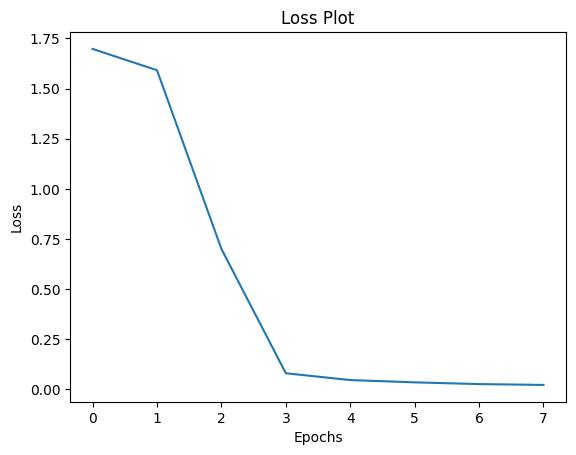

In [30]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [31]:
def map_test(img_name):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (160, 300))
    img = img/255*2-1
    return img, img_name

In [32]:
dataset_testing = tf.data.Dataset.from_tensor_slices(img_test)\
                                .map(map_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                                .batch(50)\
                                .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [33]:
# write the result to csv file, path = './Lab12-2_112062524.txt'
# the format of the csv file is:
# img_name - "./dataset/words_captcha/" , answer
with open('./Lab12-2_112062524_r_2.txt', 'w') as f:
    f.write('img_name,answer\n')
    for img_tensor, img_name in dataset_testing:
        pred_list = postprocess(predict(img_tensor).numpy())
        for img, pred in zip(img_name.numpy(), pred_list):
            f.write(f'{img.decode()}, {pred}\n')

In [34]:
# remove the "./dataset/words_captcha/" and ".png" from the img_name
df = pd.read_csv('./Lab12-2_112062524_r_2.txt')
df['img_name'] = df['img_name'].apply(lambda x: x[24:-4])
df.to_csv('./Lab12-2_112062524_3.txt', index=False)


In [36]:
# open the Lab12-2_112062524_2.txt and delete all "," in the file
# then save the file to Lab12-2_112062524_3.txt
with open('./Lab12-2_112062524_3.txt', 'r') as f:
    contents = f.read()
contents = contents.replace(',', '')

with open('./Lab12-2_112062524_resnet.txt', 'w') as f:
    f.write(contents)